In [11]:
import sys
sys.path.append('../')
from data_access.data_access_utility import ABRDataAccess
from classifier.classical_classifiers import SVM, RFClassifier, KNN

In [4]:
feature_list=['snps_nonsyn_trimmed','gpa','genexp_norm01']
ABRAccess=ABRDataAccess('/mounts/data/proj/asgari/dissertation/datasets/deepbio/pseudomonas/data_v3/',feature_list)

drug_idx=2
drug_vect=['Ciprofloxacin', 'Tobramycin', 'Colistin', 'Ceftazidim', 'Meropenem']
drug=drug_vect[drug_idx]
X,Y,features, iso=ABRAccess.get_xy_prediction_mats(drug,mapping={'0': 0, '0.0': 0, '1': 1, '1.0': 1})


Data access created..
@@@/mounts/data/proj/asgari/dissertation/datasets/deepbio/pseudomonas/data_v3/snps_nonsyn_trimmed_feature_vect.npz
@@@/mounts/data/proj/asgari/dissertation/datasets/deepbio/pseudomonas/data_v3/gpa_feature_vect.npz
@@@/mounts/data/proj/asgari/dissertation/datasets/deepbio/pseudomonas/data_v3/genexp_norm01_feature_vect.npz


In [12]:

import sys
sys.path.append('../')

import numpy
import pandas
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from utility.file_utility import FileUtility
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, precision_score, recall_score
from gensim.models.wrappers import FastText
import itertools
import os
import matplotlib.pyplot as plt
import matplotlib


class DNNAMRClassifier(object):
    
    def __init__(self, X,Y, model_arch=[500]):
        # rep. X
        self.X=X
        # encoding Y
        self.Y=Y
        self.C=len(set(Y))
        encoder = LabelEncoder()
        encoder.fit(Y)
        self.encoded_Y = encoder.transform(Y)
        self.onehot_y = np_utils.to_categorical(self.encoded_Y)
        # model's arch
        self.model_arch=model_arch
    
    def get_MLP_model(self):
        # creating the model
        model = Sequential()
        for layer_idx, h_layer_size in enumerate(self.model_arch):
            if layer_idx==0:
                model.add(Dense(h_layer_size, input_dim=self.X.shape[1], activation='relu'))
            else:
                if h_layer_size < 1:
                    model.add(Dropout(h_layer_size))
                else:
                    model.add(Dense(h_layer_size, activation='relu'))
        model.add(Dense(self.C, activation='softmax'))        
        # Compile model
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        return model
    
    def get_EMB_MLP_model(self):
        # creating the model
        model = Sequential()
        embedding=np.load('../../datasets/processed_data/embedding/WV_16s.npz')['arr_0']
        model.add(Dense(embedding.shape[1], input_dim=self.X.shape[1],  weights = [embedding, np.array([0]*1000)], trainable=False , activation='linear'))
        for layer_idx, h_layer_size in enumerate(self.model_arch):
            if h_layer_size < 1:
                model.add(Dropout(h_layer_size))
            else:
                model.add(Dense(h_layer_size, activation='relu'))
        model.add(Dense(self.C, activation='softmax'))        
        # Compile model
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        self.model_arch=[1000]+self.model_arch
        return model
    
    def get_pretrained_model(self, file_name, trainable):
        pretrained_weights=FileUtility.load_obj(file_name)
        
        h_sizes=[float(x) for x in file_name.split('/')[-1].split('_')[3].split('-')]
        model = Sequential()
        for layer_idx, h_layer_size in enumerate(h_sizes):
            if layer_idx==0:
                model.add(Dense(int(h_layer_size), input_dim=self.X.shape[1], weights=pretrained_weights[0],  activation='relu', trainable=trainable))
            else:
                if h_layer_size < 1:
                    model.add(Dropout(h_layer_size, weights=pretrained_weights[layer_idx], trainable=trainable))
                else:
                    model.add(Dense(int(h_layer_size), weights=pretrained_weights[layer_idx], activation='relu', trainable=trainable))
        if self.model_arch:
            for layer_idx, h_layer_size in enumerate(self.model_arch):
                if h_layer_size < 1:
                    model.add(Dropout(h_layer_size))
                else:
                    model.add(Dense(h_layer_size, activation='relu'))
        model.add(Dense(self.C, activation='softmax'))
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        return model
        
    
    def cross_validation(self, result_filename, gpu_dev='2', n_fold=5, epochs=50, batch_size=100, model_strct='mlp', pretrained_model=False, trainable=False):

        os.environ["CUDA_VISIBLE_DEVICES"] = gpu_dev
        
        skf = StratifiedKFold(n_splits=n_fold, shuffle=True)

        p_micro=[]
        p_macro=[]
        r_micro=[]
        r_macro=[]
        f1_micro=[]
        f1_macro=[]

        for train_index, valid_index in skf.split(self.X, self.Y):
            print ('\n Evaluation on a new fold is now get started ..')
            X_train=self.X[train_index,:]
            y_train=self.onehot_y[train_index,:]
            y_class_train=self.encoded_Y[train_index]
            X_valid=self.X[valid_index,:]
            y_valid=self.onehot_y[valid_index,:]
            y_class_valid=self.encoded_Y[valid_index]
            
            if pretrained_model:
                model=self.get_pretrained_model(model_strct, trainable)
            else:
                if model_strct=='mlp':
                    model=self.get_MLP_model()
                if model_strct=='embmlp':
                    model=self.get_EMB_MLP_model()
            
            # fitting
            history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,shuffle=True, validation_data=(X_valid, y_valid), verbose=0)
            pred=model.predict_classes(X_valid)
            # score-calculations
            f1_micro.append(f1_score(pred, y_class_valid, average='micro'))
            f1_macro.append(f1_score(pred, y_class_valid, average='macro'))
            p_micro.append(precision_score(pred, y_class_valid, average='micro'))
            p_macro.append(precision_score(pred, y_class_valid, average='macro'))
            r_micro.append(recall_score(pred, y_class_valid, average='micro'))
            r_macro.append(recall_score(pred, y_class_valid, average='macro'))

        # mean values
        f1mac=np.mean(f1_macro)
        f1mic=np.mean(f1_micro)
        prmac=np.mean(p_macro)
        prmic=np.mean(p_micro)
        remac=np.mean(r_macro)
        remic=np.mean(r_micro)
        # std values
        sf1mac=np.std(f1_macro)
        sf1mic=np.std(f1_micro)
        sprmac=np.std(p_macro)
        sprmic=np.std(p_micro)
        sremac=np.std(r_macro)
        sremic=np.std(r_micro)
        # table
        latex_line=' & '.join([str(np.round(x,2))+' $\\pm$ '+str(np.round(y,2)) for x,y in [[prmic, sprmic], [remic, sremic], [f1mic, sf1mic], [prmac, sprmac], [remac, sremac], [f1mac, sf1mac] ]])      
        
        print (latex_line)
        
        
        
        history_dict = history.history
        loss_values = history_dict['loss']
        val_loss_values = history_dict['val_loss']
        epochs = range(1, len(loss_values) + 1)

        if pretrained_model:
            model_strct='pretrained'
            #print (model.summary())
        FileUtility.save_obj('_'.join([result_filename, model_strct,'-'.join([str(x) for x in self.model_arch]), str(np.round(f1mac,2))]), [latex_line, p_micro, r_micro, f1_micro, p_macro, r_macro, f1_macro, (loss_values, val_loss_values, epochs)])
        
        weights=[]
        for x in model.layers:
            weights.append(x.get_weights())
        
        FileUtility.save_obj('_'.join([result_filename, 'layers', model_strct,'-'.join([str(x) for x in self.model_arch]), str(np.round(f1mac,2))]), weights)
        FileUtility.save_list('_'.join([result_filename, 'train_index', model_strct,'-'.join([str(x) for x in self.model_arch]), str(np.round(f1mac,2))]),train_index)
        FileUtility.save_list('_'.join([result_filename, 'test_index', model_strct,'-'.join([str(x) for x in self.model_arch]), str(np.round(f1mac,2))]),valid_index)    

    @staticmethod
    def load_history(filename, fileout):
        [latex_line, p_micro, r_micro, f1_micro, p_macro, r_macro, f1_macro, history]=FileUtility.load_obj(filename)
        (loss_values, val_loss_values, epochs)=history
        matplotlib.rcParams['mathtext.fontset'] = 'stix'
        matplotlib.rcParams['font.family'] = 'STIXGeneral'
        matplotlib.rcParams['mathtext.fontset'] = 'custom'
        matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
        matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
        matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
        matplotlib.rcParams["axes.edgecolor"] = "black"
        matplotlib.rcParams["axes.linewidth"] = 0.6
        plt.rc('text', usetex=True)
        plt.plot(epochs, loss_values, 'ro', label='Loss for train set')
        plt.plot(epochs, val_loss_values, 'b+', label='Loss for test set')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend(loc=1, prop={'size': 8},ncol=1, edgecolor='black', facecolor='white', frameon=True)
        plt.title('Loss with respect to the number of epochs for train and test sets')
        plt.savefig(fileout+'.pdf')
        plt.show()
        
        
    @staticmethod
    def make_activation_function(file_name, X, last_layer=None):
        pretrained_weights=FileUtility.load_obj(file_name)
        if last_layer:
            h_sizes=[float(x) for x in file_name.split('/')[-1].split('_')[3].split('-')]+[last_layer]
        else:
            h_sizes=[float(x) for x in file_name.split('/')[-1].split('_')[3].split('-')]
        model = Sequential()
        for layer_idx, h_layer_size in enumerate(h_sizes):
            if layer_idx==0:
                model.add(Dense(int(h_layer_size), input_dim=X.shape[1], weights=pretrained_weights[0],  activation='relu'))
            else:
                if h_layer_size < 1:
                    model.add(Dropout(h_layer_size, weights=pretrained_weights[layer_idx]))
                else:
                    if layer_idx == len(h_sizes)-1 and last_layer:
                        model.add(Dense(int(h_layer_size), weights=pretrained_weights[layer_idx], activation='softmax'))
                    else:
                        model.add(Dense(int(h_layer_size), weights=pretrained_weights[layer_idx], activation='relu'))
        activations = model.predict(X)
        np.savetxt(file_name.replace(file_name.split('/')[-1].split('_')[0],'activationlayer'),activations)
        return activations
    
    
    @staticmethod
    def result_visualization(filename):
        [latex_line, p_micro, r_micro, f1_micro, p_macro, r_macro, f1_macro, (loss_values, val_loss_values, epochs)]=FileUtility.load_obj(filename)
        print(latex_line)




In [ ]:
for drug_idx in [0,1,2,3,4]:
    drug_vect=['Ciprofloxacin', 'Tobramycin', 'Colistin', 'Ceftazidim', 'Meropenem']
    drug=drug_vect[drug_idx]
    X,Y,features, iso=ABRAccess.get_xy_prediction_mats(drug,mapping={'0': 0, '0.0': 0, '1': 1, '1.0': 1})
    DNN=DNNAMRClassifier(X.toarray(),Y,model_arch=[1000,0.2,512])
    DNN.cross_validation('../results/classification/dnn/classifier_'+drug, gpu_dev='2', n_fold=3, epochs=30, batch_size=3, model_strct='mlp')




 Evaluation on a new fold is now get started ..
128/128 [==============================] - 0s     

 Evaluation on a new fold is now get started ..


/mounts/Users/student/asgari/.local/lib/python3.4/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/mounts/Users/student/asgari/.local/lib/python3.4/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [9]:
history=DNN.history
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

AttributeError: 'DNNAMRClassifier' object has no attribute 'history'

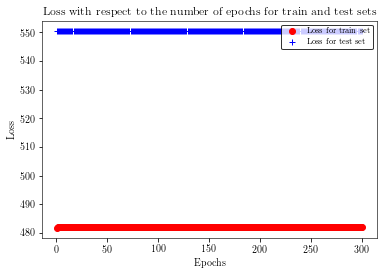

In [219]:
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
matplotlib.rcParams["axes.edgecolor"] = "black"
matplotlib.rcParams["axes.linewidth"] = 0.6
plt.rc('text', usetex=True)
plt.plot(epochs, loss_values, 'ro', label='Loss for train set')
plt.plot(epochs, val_loss_values, 'b+', label='Loss for test set')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc=1, prop={'size': 8},ncol=1, edgecolor='black', facecolor='white', frameon=True)
plt.title('Loss with respect to the number of epochs for train and test sets')
plt.show()
        

In [220]:
Y_hat=DNN.model.predict_on_batch(X[1:6,:])

In [221]:
X[1:6,:]

array([[ 0.        ,  0.        ,  0.        , ...,  0.01805095,
        -0.00303337,  0.00430073],
       [ 1.        ,  0.        ,  0.        , ..., -0.01002263,
         0.01075347, -0.01498816],
       [ 0.        ,  0.        ,  0.        , ...,  0.01681682,
        -0.01322764,  0.02109493],
       [ 0.        ,  0.        ,  0.        , ...,  0.01847024,
        -0.01287623,  0.02317673],
       [ 0.        ,  0.        ,  1.        , ...,  0.01630178,
        -0.00991178,  0.02462367]])

In [222]:
np.max(Y_hat)

0.0

In [223]:
Y_hat

array([[ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.]], dtype=float32)